In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.optim

%matplotlib inline

In [ ]:
words = open('names.txt', 'r').read().splitlines()

# count bigrams (character sequences), sample from the "model"

In [ ]:
N = torch.zeros((27, 27), dtype=torch.int32)

In [ ]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [ ]:

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

# neural network approach

In [ ]:
P = (N+1).float()  # the +1 is for model smoothing, to avoid possibility of -inf likelihoods below
P /= P.sum(1, keepdims=True)

In [ ]:
g = torch.Generator().manual_seed(2147483647)

names = []

for i in range(5):
  out = []
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  names.append(''.join(out)[:-1])
names

In [ ]:
log_likelihood = 0
n = 0

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        # log liklihood
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        #print(f'{ch1}{ch2}: {prob:.4f} : {logprob:.4f}')
print(f'{log_likelihood=}')
nll = - log_likelihood
print(f'{nll=}')
print(f'{(nll/n)=}')  # loss function, want to minimize towards 0

In [ ]:
# create the training set of all the bigrams

xs, ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [ ]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc.shape

In [ ]:
plt.imshow(xenc)

In [ ]:
W = torch.randn((27, 1))

# shape of matrix multiplication: (5,27) @ (27,1) = (5, 1)
# 5 output values are the 5 activations of the neuron for 5 inputs, evaluated in parallel
xenc @ W

In [ ]:
# changing from 1 neuron to 27 neurons
# shape: (5,27) @ (27,27) = (5,27)
# for every 1 of 27 neurons, what is the firing rate of those neurons for each input
# e.g. (xenc @ W)[3, 13] is looking at firing rate of 13th neuron for 3rd input
W = torch.randn((27, 27))
xenc @ W

In [ ]:
logits = xenc @ W  # log-counts
counts = logits.exp()  # equivalent to N, counts of next character
probs = counts / counts.sum(1, keepdims=True)  # probabilities
probs
# for each of the 5 input examples, have a (1,27) row of probabilities of the next character

# cleaned up neural network approach

In [ ]:
# inputs to nn
xs

In [ ]:
#  labels for correct next character
ys

In [60]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g)

### forward pass

In [ ]:
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
# btw: next 2 lines here are together called a 'softmax'
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character

In [ ]:
probs.shape

### exploration of nn performance, before training
aggregate loss is 3.76, not very good

In [ ]:

nlls = torch.zeros(5)
for i in range(5):
    # i-th bigram:
    x = xs[i].item() # input character index
    y = ys[i].item() # label character index
    print('--------')
    print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
    print('input to the neural net:', x)
    print('output probabilities from the neural net:', probs[i])
    print('label (actual next character):', y)
    p = probs[i, y]
    print('probability assigned by the net to the the correct character:', p.item())
    logp = torch.log(p)
    print('log likelihood:', logp.item())
    nll = -logp
    print('negative log likelihood:', nll.item())
    nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

### add backward pass and update steps

- loss function above is made up only of differentiable operations
- can minimize loss by tuning w's, compute gardients of the loss with respect to w matrices
- can tune w's to minimize loss


picking up with techniques very similar to where left off with micrograd...

#### micrograd for reference

```
 for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # MSE loss. (prediction - ground truth) ^ 2
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
```

In [54]:
torch.arange(5)

tensor([0, 1, 2, 3, 4])

In [92]:
# create the training set of all the bigrams

xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the "network"
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  228146


In [110]:
# gradient descent
losses = []
m = int(10e2)

for k in range(m):

    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
    #loss = -probs[torch.arange(num), ys].log().mean()
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()  # loss with regularization, to apply force pushing W's to 0
    losses.append(loss.item())
    #print(f'{loss.item()=}')

    # backward pass
    W.grad = None  # zero the gradients
    loss.backward()

    # update
    W.data += -50 * W.grad

loss.item()=2.480422019958496


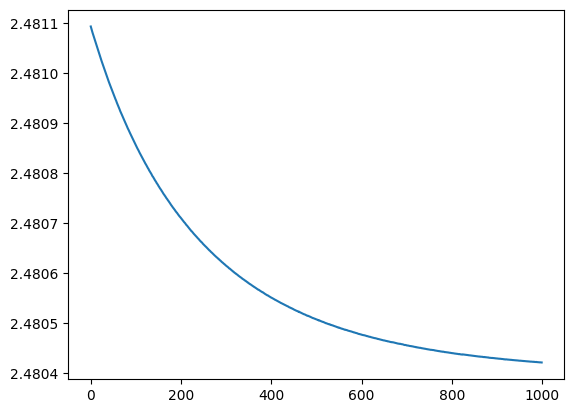

In [111]:
plt.plot(losses)
print(f'{loss.item()=}')

### sampling from trained nn

In [113]:
g = torch.Generator().manual_seed(2147483647)

names = []
for i in range(10):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    #print(''.join(out))
    names.append(''.join(out)[:-1])
names

['junide',
 'janasah',
 'p',
 'cony',
 'a',
 'nn',
 'kohin',
 'tolian',
 'juee',
 'ksahnaauranilevias']